# Uniaxial tension of plate with 3 central holes
# Energy-based neural network

## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## User defined neural network
* A fully-connected feed-forward network
    * **n_input** - dimension of input, 2 in this case(x and y lcation)
    * **n_output** - dimension of output, 1 in this case (u - horizontal or v - vertical displacemnt)
    * **n_layer** - number of hidden layers
    * **n_nodes** - number of nodes of each hidden layer
* **two networks are defined seperately for u and v**

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)   # linear layer
        nn.init.xavier_uniform_(self.Input.weight) # wigths and bias initiation
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList() # hidden layer list
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        

    def forward(self, x):
        y = torch.tanh(self.Input(x)) # tanh activation function
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

## Functions for first and sencod partial derivtives

In [3]:
def derivativs2(x, Net, func):
    
    w = Net(x)*func(x).view(-1,1)
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return w, dw_x, dw_y

## Construct the loss of PDE and boundary condition

In [4]:
def PDE(x, Net_u, func_u, Net_v, func_v):
    
    E = 70
    mu = 0.3
    a = 10
    b = 10
    C = E/(1 - mu**2)
    
    _, du_x, du_y = derivativs2(x, Net_u, func_u) 
    _, dv_x, dv_y = derivativs2(x, Net_v, func_v)
    
    du_y, dv_x = du_y*a/b, dv_x*b/a
    
    eps_xx = du_x 
    eps_yy = dv_y 
    eps_xy = 0.5*(du_y + dv_x)
    
    sig_xx = C*(eps_xx + mu*eps_yy)
    sig_yy = C*(eps_yy + mu*eps_xx)
    sig_xy = C*(1 - mu)*eps_xy

    res = 0.5*(eps_xx*sig_xx + eps_yy*sig_yy + 2*eps_xy*sig_xy)

    return torch.mean(res)

## Function for preparing training data
* **uniform sampling at the boundary and radom sampling within the solution domain**

In [5]:
def train_data2(Nx, Ny, Nc, Nf, Nf1):
    
    x0 = 1
    y0 = 1


    X2 = np.hstack([ x0*np.ones([Nx,1]), np.random.rand(Nx,1)*y0*2 -1])
    
    Xb = torch.tensor(X2, dtype=torch.float32, requires_grad=True)

    Y2 = np.hstack([np.random.rand(Nx,1)*x0,  y0*np.ones([Ny,1])])
    Yb = torch.tensor(Y2, dtype=torch.float32, requires_grad=True)
    
    Xf = np.random.rand(Nf, 2)*2 - 1
    index0 = []
    #Xf = np.copy(Xf0)
    for i, (x, y) in enumerate(Xf):

        #x, y = x*x0, y*y0
        if (circle(0.2, 0.2, 0.2, 0.2, x, y) > 0.5625) and (circle(-0.2, 0.4, 0.1, 0.1, x, y) > 0.5625) and (circle(-0.2, -0.3, 0.3, 0.3, x, y) > 0.5625):
            index0.append(i)
    Xf0 = Xf[index0]
    
    Xf = np.random.rand(Nf1, 2)*2 - 1
    index1 = []
    index2 = []
    index3 = []
    
    for i, (x, y) in enumerate(Xf):
        
        if (circle(0.2, 0.2, 0.2, 0.2, x, y) > 0.0 and circle(0.2, 0.2, 0.2, 0.2, x, y) < 0.5625):
            index1.append(i)
            
        if (circle(-0.2, 0.4, 0.1, 0.1, x, y) > 0.0 and circle(-0.2, 0.4, 0.1, 0.1, x, y) < 0.5625):
            index2.append(i)
            
        if (circle(-0.2, -0.3, 0.3, 0.3, x, y) > 0.0 and circle(-0.2, -0.3, 0.3, 0.3, x, y) < 0.5625):
            index3.append(i)
    
    Xf1 = Xf[index1]
    Xf2 = Xf[index2]
    Xf3 = Xf[index3]
    
    Xf0 = torch.tensor(Xf0, dtype=torch.float32, requires_grad=True)
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)
    Xf3 = torch.tensor(Xf3, dtype=torch.float32, requires_grad=True)
    
    return Xb, Yb, Xf0, Xf1, Xf2, Xf3

In [6]:
def circle(x0, y0, ra, rb, xt, yt):
    
    return (xt - x0)**2/ra**2 + (yt - y0)**2/rb**2 - 1

In [7]:
a = 10
b = 10

In [8]:
# Prepare training data
Nx = 1000
Ny = 1000
Nc = 250
Nf = 5000
Nf1 = 30000
#Xb1, Xb2, Xf = train_data(Nx, Ny, Nc, Nf)
Xb1, Xb2, Xf0, Xf1, Xf2, Xf3 = train_data2(Nx, Ny, Nc, Nf, Nf1)
#print(Xb1, Xb2, Xb3, Xf)
# Construct neural network
Net_u = Net(2, 1, 5, 5)
Net_v = Net(2, 1, 5, 5)
func_u = lambda x:  (x[:,0]+1)
func_v = lambda x:  (x[:,0]+1)

In [9]:
def plot_pos(Xf0, Xf1, Xf2, Xf3, Xb1, Xb2):
    
    Xf0 = Xf0.detach().numpy()
    Xf1 = Xf1.detach().numpy()
    Xf2 = Xf2.detach().numpy()
    Xf3 = Xf3.detach().numpy()
    
    Xb1 = Xb1.detach().numpy()
    Xb2 = Xb2.detach().numpy()
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
    surf = ax.scatter(Xf0[:,0], Xf0[:,1], s=1, c='b', marker='x')
    plt.scatter(Xf1[:,0], Xf1[:,1], s=1, c='r', marker='x')
    plt.scatter(Xf2[:,0], Xf2[:,1], s=1, c='r', marker='x')
    plt.scatter(Xf3[:,0], Xf3[:,1], s=1, c='r', marker='x')
    
    #plt.plot([0,0], [0,1], c='k', alpha=0.5)
    #plt.plot([0,1], [0,0], c='k', alpha=0.5)
    #plt.plot([1,1], [0,1], c='k', alpha=0.5)
    #plt.plot([0,1], [1,1], c='k', alpha=0.5)
    plt.scatter(Xb1[:,0], Xb1[:,1], s=0.1, c='k', marker='x')
    #plt.scatter(Xb2[:,0], Xb2[:,1], s=0.1, c='k', marker='x')
    #cbar = fig.colorbar(ax)
    #cb = fig.colorbar(surf, ticks=[0,0.03,0.06,0.09,0.12,0.15,0.18])
    #cb.ax.locator_params(nbins=7)
    #cb.ax.tick_params(labelsize=16)
    #cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
    #cb.set_label(fontsize=16)
    ax.axis('equal')
    ax.set_xlabel('X Position (mm)', fontsize=18)
    ax.set_ylabel('Y Position (mm)', fontsize=18)
    for tick in ax.get_xticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(16)
    for tick in ax.get_yticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(16)
    #plt.savefig('CH-2hole-Sample.png', dpi=600, transparent=True)
    plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


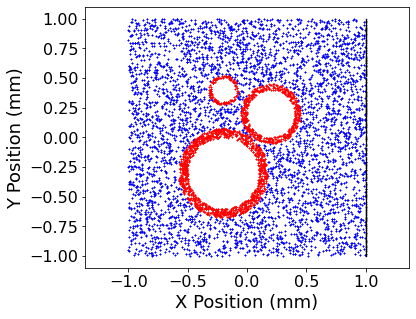

In [10]:
plot_pos(Xf0, Xf1, Xf2, Xf3, Xb1, Xb2)

In [11]:
import time

In [ ]:
start_time = time.time()
# Construct neural network
# optimizer
nepoches = 6000
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(list(Net_u.parameters())+list(Net_v.parameters()), lr=learning_rate)

training_loss = []
for epoch in range(nepoches):
    ## Calculate loss
    a = 10
    b = 10
    q = 1.0
    ra = 2
    rb = 2
    
    Eint0 = PDE(Xf0, Net_u, func_u, Net_v, func_v)*(4*a*b - 3.1415926*(1+2**2+3**2)*1.25**2)
    Eint1 = PDE(Xf1, Net_u, func_u, Net_v, func_v)*3.1415926*4*(1.25**2 - 1)
    Eint2 = PDE(Xf2, Net_u, func_u, Net_v, func_v)*3.1415926*1*(1.25**2 - 1)
    Eint3 = PDE(Xf3, Net_u, func_u, Net_v, func_v)*3.1415926*9*(1.25**2 - 1)
    
    Eint = Eint0 + Eint1 + Eint2 + Eint3
    Eext = torch.mean(q *Net_u(Xb1)*func_u(Xb1).view(-1,1))*a*2*b
    #Eint, Eext = Eint, Eext
    loss = Eint - Eext
    #loss = torch.abs(loss)
    loss.backward()
    #ind = 0
    #loss_list = [loss1, loss2 + loss3 + loss4, loss5 + loss6, loss7 + loss8]
    loss_temp = loss
    training_loss.append(loss_temp.detach().numpy())
    if (epoch+1) % 200 == 0:
        Xb1, Xb2, Xf0, Xf1, Xf2, Xf3 = train_data2(Nx, Ny, Nc, Nf, Nf1)
    
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}: total loss:{loss:.4e}, Eint:{Eint:.4e}, Eext:{Eext:.4e} ')
elapsed_time = time.time() - start_time
print(elapsed_time)

In [14]:
import pandas as pd

In [15]:
data = pd.read_csv('CH-3-Hole-FE.csv')
X_train = data.iloc[:, 1:3].to_numpy()
U = data.iloc[:,3:5].to_numpy()
sig = data.iloc[:,5:8].to_numpy()
U1 = U[:,0].reshape(-1, 1)
U2 = U[:,1].reshape(-1, 1)

sig11 = sig[:,0].reshape(-1, 1)
sig22 = sig[:,1].reshape(-1, 1)
sig12 = sig[:,2].reshape(-1, 1)

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_train = X_train/10
U = torch.tensor(U, dtype=torch.float32)
U = U / 10

In [17]:
u1 = Net_u(X_train)*func_u(X_train).view(-1,1)
u2 = Net_v(X_train)*func_v(X_train).view(-1,1)

u1 = u1.detach().numpy().reshape(-1,1)*10
u2 = u2.detach().numpy().reshape(-1,1)*10

X = X_train[:,0].detach().numpy().reshape(-1,1)*10
Y = X_train[:,1].detach().numpy().reshape(-1,1)*10

In [35]:
max(u1)

array([0.31897247], dtype=float32)

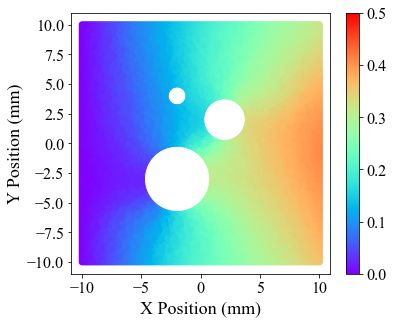

In [40]:
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = u1, vmin=0, vmax=0.5, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf, ticks=[0,0.1,0.2,0.3,0.4,0.5])
#cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Time s New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('CH-R2-U-Energy-10-10.png', dpi=600, transparent=True)
plt.show()

In [41]:
_, du_x, du_y,= derivativs2(X_train, Net_u, func_u)
_, dv_x, dv_y,= derivativs2(X_train, Net_v, func_v)

E, mu = 70, 0.3
sig_x = (du_x + mu*dv_y)*E/(1 - mu**2) 
sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

#X = Xf[:,0].detach().numpy().reshape(-1,1)
#Y = Xf[:,1].detach().numpy().reshape(-1,1)

sig_x = sig_x.detach().numpy()
sig_y = sig_y.detach().numpy() 
sig_xy = sig_xy.detach().numpy()

#err = abs(sig_x - sig11)

In [42]:
max(sig_x)

array([3.9444506], dtype=float32)

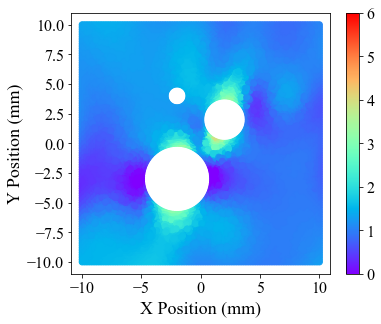

In [48]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = sig_x, vmin=0, vmax=6.0, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf)
cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
plt.savefig('CH-2Hole-S-Energy-10-10.png', dpi=600, transparent=True)
plt.show()

In [74]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),u1,u2,sig_x,sig_y,sig_xy])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [75]:
df_out.to_csv('CH-3-Hole-NN10-10.csv')